**Name:** Amulya Gunturu

Provide a code to pull your data, ideally from a raw source, and prepare it for model training.  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
#Maybe try a simplier CNN-LTSM architecture such as ... 

#https://stackoverflow.com/questions/44778439/keras-tf-time-distributed-cnnlstm-for-visual-recognition

# Hints

You are able to execute some commands on the remote instance on which you code will run.  

In [ ]:
# Checking disk space
!df -m

# Checking my privileges 
!whoami

! mkdir /content/drive/CPS580-Project/

! ls /content/

!wget --no-check-certificate \
    https://drive.google.com/file/d/1vagzHXnnZPH1AiIxh1Ui70SEMrw1LOSE/view?usp=sharing

! cd /content/drive/MyDrive/CPS580-Project/ && unzip driving_dataset.zip > /dev/null


Filesystem     1M-blocks  Used Available Use% Mounted on
overlay           110301 42646     67639  39% /
tmpfs                 64     0        64   0% /dev
tmpfs               6496     0      6496   0% /sys/fs/cgroup
shm                 5849     0      5849   0% /dev/shm
/dev/root           1957  1137       821  59% /sbin/docker-init
tmpfs               6496     1      6496   1% /var/colab
/dev/sda1          82629 46522     36092  57% /etc/hosts
tmpfs               6496     0      6496   0% /proc/acpi
tmpfs               6496     0      6496   0% /proc/scsi
tmpfs               6496     0      6496   0% /sys/firmware
drive              15360  4726     10635  31% /content/drive
root
mkdir: cannot create directory ‘/content/drive/CPS580-Project/’: Operation not supported
drive  sample_data
--2021-11-26 05:45:48--  https://drive.google.com/file/d/1vagzHXnnZPH1AiIxh1Ui70SEMrw1LOSE/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 108.177.125.102, 108.177.125.100, 108.177.125

In [ ]:
! ls /content/drive/MyDrive/CPS580-Project

#! df -h


dataset  driving_dataset  driving_dataset.zip  __MACOSX


In [ ]:
! pip install scikit-image

Resizing the input images and Dividing the Train and Test data from the input

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import PIL
import imageio
import scipy.misc
import random
from skimage.transform import resize
from PIL import Image
import numpy

from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import layers
from keras import models
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense, TimeDistributed, InputLayer
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
import numpy as np

from keras.layers import BatchNormalization

from sklearn.metrics import mean_squared_error

import toolz
from toolz.itertoolz import sliding_window

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras import regularizers

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras

from matplotlib.pyplot import imshow


In [ ]:
# data_count= len(list(glob('/content/drive/MyDrive/CPS580-Project/driving_dataset/*.jpg')))
# print("No. of driving test images are:",data_count)

x = []
y = []
counter = 0

#read data.txt
with open("/content/drive/MyDrive/CPS580-Project/driving_dataset/data.txt") as f:
    for line in f:
        x.append("drive/MyDrive/CPS580-Project/driving_dataset/" + line.split()[0]) # Image frame name
        y.append(float(line.split()[1]) * scipy.pi / 180) # Steering angle in radians (Normalization)
        counter += 1
        if counter == 3000: 
          break

# counting the no. of image frames.
num_images = len(x)
print(num_images)

train_X = x[:int(len(x) * 0.6)]
train_Y = numpy.asarray(y[:int(len(x) * 0.6)])
#print(train_X[0])

val_X = x[-int(len(x) * 0.4):-int(len(x) * 0.2)]                    #### ARE THE VAL AND TEST DATA THE SAME?
val_Y = numpy.asarray(y[-int(len(x) * 0.4):-int(len(x) * 0.2)])
#print(val_X[599])

test_X = x[-int(len(x)*0.2):]
test_Y = numpy.asarray(y[-int(len(x) * 0.2):])
#print(test_X[599])

num_train_images = len(train_X)
print("No. of training images",num_train_images)
num_train_angles = len(train_Y)
print("No. of training angles corresponding to training images",num_train_angles)

num_val_images = len(val_X)
print("No. of validation images",num_val_images)
num_val_angles = len(val_Y)
print("No. of training angles corresponding to training images",num_val_angles)

num_test_images = len(test_X)
print("No. of training images",num_test_images)
num_test_angles = len(test_Y)
print("No. of training angles corresponding to training images",num_test_angles)


3000
No. of training images 1800
No. of training angles corresponding to training images 1800
No. of validation images 600
No. of training angles corresponding to training images 600
No. of training images 600
No. of training angles corresponding to training images 600


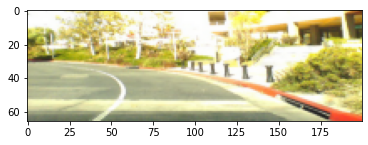

In [ ]:
train_X_image = imageio.imread(train_X[484])
train_X_resize = (resize(train_X_image, [66, 200]))
plt.imshow(train_X_resize)

Loading all the train and test data after resizing

In [ ]:
# Resizing training images
train_X_resize = []
for i in range (num_train_images):
# Image size check for a random image
    image_read_train = np.array(imageio.imread(train_X[i]))
    #print("original image size",image_read.shape)

# Resizing the last 150 images
    #print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
    image_read = image_read_train[-150:]
    resized_image_train = (resize(image_read, [66, 200]))
    resized_image_train = resized_image_train.astype("float32")
    resized_image_train /= 255.
    train_X_resize.append(resized_image_train)
    train_X_final = np.array(train_X_resize)
    #print("After resizing the images into 66*200, ",resized_image.shape)

# 200/66 = 455/150 = 3.0303 => Trying to keep aspect ratio while resizing. That's why I choose 66x200
# imageio.imresize(scipy.misc.imread(train_X[0])[-150:], [66, 200])

In [ ]:
print(train_X_final.shape)

(1800, 66, 200, 3)


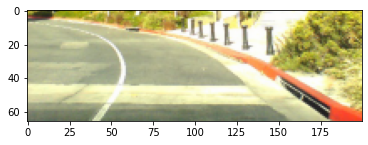

In [ ]:
plt.imshow(train_X_final[484])

In [ ]:
# Resizing validation images
val_X_resize = []
for i in range (num_val_images):
# Image size check for a random image
    image_read_val = np.array(imageio.imread(val_X[i]))
    #print("original image size",image_read.shape)

# Resizing the last 150 images
    #print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
    image_read = image_read_val[-150:]
    resized_image = (resize(image_read, [66, 200]))
    resized_image = resized_image.astype("float32")
    resized_image /= 255.
    val_X_resize.append(resized_image)
    val_X_final = np.array(val_X_resize)
    #print("After resizing the images into 66*200, ",resized_image.shape)

# 200/66 = 455/150 = 3.0303 => Trying to keep aspect ratio while resizing. That's why I choose 66x200
# imageio.imresize(scipy.misc.imread(train_X[0])[-150:], [66, 200])

In [ ]:
print(val_X_final.shape)

(600, 66, 200, 3)


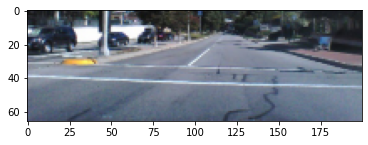

In [ ]:
plt.imshow(val_X_final[484])

In [ ]:
# Resizing test images
test_X_resize = []
for i in range (num_test_images):
# Image size check for a random image
    image_read = imageio.imread(test_X[i])
    #print("original image size",image_read.shape)

# Resizing the last 150 images
    #print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
    image_read = image_read[-150:]
    resized_image = (resize(image_read, [66, 200]))
    resized_image = resized_image.astype("float32")
    resized_image /= 255.
    test_X_resize.append(resized_image)
    test_X_final = np.array(test_X_resize)
    #print("After resizing the images into 66*200, ",resized_image.shape)

# 200/66 = 455/150 = 3.0303 => Trying to keep aspect ratio while resizing. That's why I choose 66x200
# imageio.imresize(scipy.misc.imread(train_X[0])[-150:], [66, 200])

In [ ]:
print(test_X_final.shape)   #### VISUALIZE A FEW OF THE IMAGES IN TEXT_X and TRAIN_X TO MAKE SURE THEY WERE READ IN CORRECTLY
                            #### DISPLAY WITH STEERING ANGLE AS WELL

(600, 66, 200, 3)


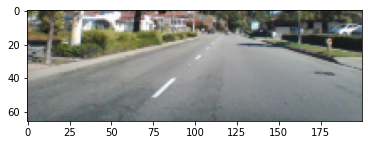

In [ ]:
plt.imshow(test_X_final[484])

Visualiazing the data

<BarContainer object of 100 artists>

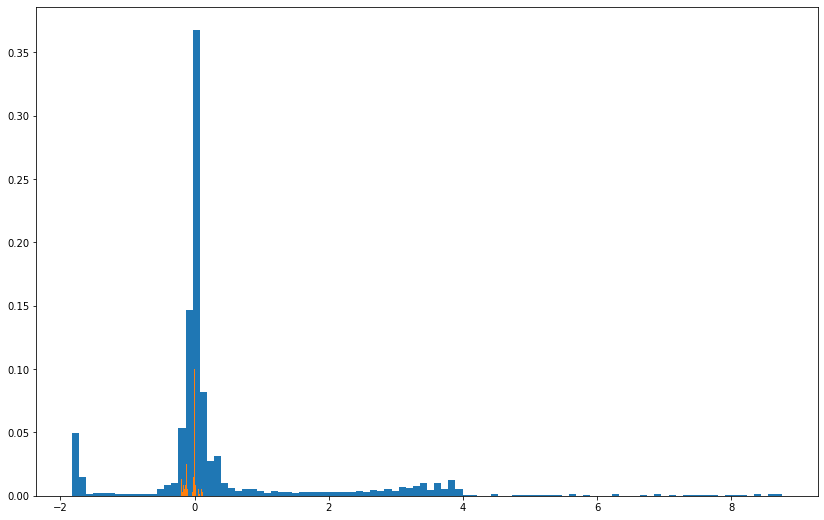

In [ ]:
# computing histogram
hist, bins = np.histogram(train_Y, bins = 100, density = True)
# width of each bin
bins_w = np.diff(bins)
#proportion of sample in each bin
hist_p = hist * bins_w
# plotting histogram
plt.bar(bins[:-1], hist_p, width = bins_w, align ='edge')

hist, bins = np.histogram(test_Y, density = True, bins = 100)
bins_w = np.diff(bins)
hist_p = hist * bins_w

plt.bar(bins[:-1], hist_p, width = bins_w, align ='edge')

In [ ]:
# Baseline model

train_Y_mean = np.mean(train_Y)

print("Mean Square Error Test_MSE(mean):" , np.mean(np.square(test_Y - train_Y_mean)))

Mean Square Error Test_MSE(mean): 0.2086971742844763


**Model 1** - Simple Convolution Neural Network

In [ ]:
# Convolutional layers
cnn_model = models.Sequential()
# 1st CNN layer
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(66, 200, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))
# 2nd CNN layer
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
#3rd CNN layer
cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
#4th CNN layer
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#5th CNN layer
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Dense, fully connected layers
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))
cnn_model.add(layers.Dense(1))

# Dump shape of model
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 198, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 99, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 97, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 46, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 23, 128)       0

Training the above CNN Model

In [ ]:
cnn_model.compile(loss='mse', optimizer = 'adam', metrics=['mae']) # compiling the model

history = cnn_model.fit(train_X_final,train_Y, epochs=10, batch_size= 160, validation_data = (val_X_final,val_Y)) # training the model

Epoch 1/10
12/12 [==============================] - 40s 3s/step - loss: 2.3557 - mae: 0.7409 - val_loss: 0.0392 - val_mae: 0.1954
Epoch 2/10
12/12 [==============================] - 38s 3s/step - loss: 2.1877 - mae: 0.9399 - val_loss: 0.1799 - val_mae: 0.4229
Epoch 3/10
12/12 [==============================] - 38s 3s/step - loss: 2.1669 - mae: 0.9082 - val_loss: 0.1409 - val_mae: 0.3740
Epoch 4/10
12/12 [==============================] - 38s 3s/step - loss: 2.1673 - mae: 0.9091 - val_loss: 0.1650 - val_mae: 0.4049
Epoch 5/10
12/12 [==============================] - 38s 3s/step - loss: 2.1667 - mae: 0.9181 - val_loss: 0.1555 - val_mae: 0.3930
Epoch 6/10
12/12 [==============================] - 38s 3s/step - loss: 2.1672 - mae: 0.8988 - val_loss: 0.1607 - val_mae: 0.3995
Epoch 7/10
12/12 [==============================] - 38s 3s/step - loss: 2.1680 - mae: 0.9312 - val_loss: 0.1779 - val_mae: 0.4206
Epoch 8/10
12/12 [==============================] - 38s 3s/step - loss: 2.1676 - mae: 0.92

In [ ]:
cnn_model.save('cnn_model.h5') # saving the model
#cnn_model = load_model('cnn_model.h5') # loading the saved model

Evaluating above model on test data set

In [ ]:
cnn_model.evaluate(test_X_final,test_Y) # evaluating the model with test data

19/19 [==============================] - 3s 178ms/step - loss: 0.1959 - mae: 0.4352


[0.19592750072479248, 0.43515101075172424]

Comparing the model prediction on test images with test angles and finding the mean squared error between two of them

In [ ]:
cnn_pred = cnn_model.predict(test_X_final) # assigning the predicted angles by the model for test images to cnn_pred

In [ ]:
print('test_mean_squared_error')
mean_squared_error(test_Y,cnn_pred) #calculating mean squared error between the model predicted angles and test labels

test_mean_squared_error


0.19592750685271385

Visualization of accuracy and loss for the above model

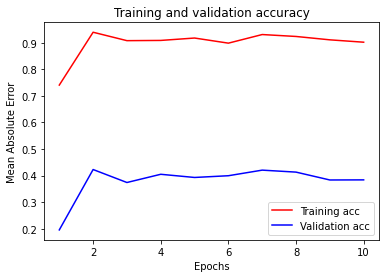

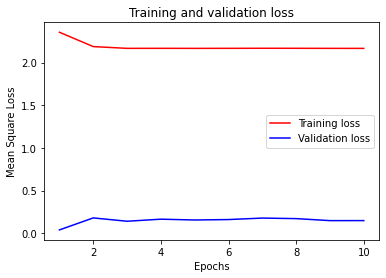

In [ ]:
### SHOW SOME PREDICTIONS AS WELL ALONG SIZE TRUE VALUE

# Visualization of accuracy and loss
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Loss')
plt.show()

Visualizing test predictions to the test labels

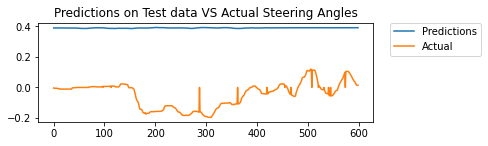

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(cnn_pred, label = 'Predictions')
Actual = plt.plot(test_Y, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles") # title for the figure
plt.rcParams["figure.figsize"] = [14,9] # figure sizing
plt.savefig('test_predcitions_vs_labels') # saving the figure
plt.show()

**Model 2** - CNN + LSTM

In [ ]:
#from keras.layers import TimeDistributedConvolution2D
#from keras.layers.extra import TimeDistributedConvolution2D, TimeDistributedMaxPooling2D, TimeDistributedFlatten


# Convolutional layers
clstm_model = models.Sequential()

clstm_model.add(layers.InputLayer(input_shape=(3,66, 200, 3)))

# 1st CNN layer
clstm_model.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
#clstm_model.add(layers.TimeDistributed(MaxPooling2D(2, 2)))

# 2nd CNN layer
clstm_model.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
clstm_model.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#3rd CNN layer
#clstm_model.add(layers.TimeDistributed(Convolution2D(128, (3, 3), activation='relu')))
#clstm_model.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#4th CNN layer
#clstm_model.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
#clstm_model.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#5th CNN layer
#clstm_model.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
clstm_model.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

clstm_model.add(layers.TimeDistributed(Flatten()))

#LSTM Layer

clstm_model.add(BatchNormalization(input_shape = (None, 3, 640)))
clstm_model.add(LSTM(256, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 3, 640)))

# Dense, fully connected layers
clstm_model.add(Dense(64))
clstm_model.add(Dense(32))
clstm_model.add(Dense(1))

#Dump the layer
clstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 3, 64, 198, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 3, 62, 196, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 3, 31, 98, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 3, 15, 49, 64)    0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 3, 47040)         0

In [ ]:
#Function to create sequences, input to the lSTM                                #### I think your sliding window needs to be greater than 1, otherwise you don't have a sequence but just one image
#function using sliding window to create sequences for array of input images
def create_sequences(size, data):
    sequence = list(sliding_window(size, data))
    sequence = np.array(sequence)
    return sequence

train_X_sequence = create_sequences(3, train_X_final)
train_Y_sequence = np.array(train_Y[:1798])
val_X_sequence = create_sequences(3, val_X_final)
val_Y_sequence = np.array(train_Y[:598])
test_X_sequence = create_sequences(3, test_X_final)
test_Y_sequence = np.array(train_Y[:598])

In [ ]:
print(train_X_sequence.shape)
print(train_Y_sequence.shape)
print(val_X_sequence.shape)
print(val_Y_sequence.shape)

(1798, 3, 66, 200, 3)
(1798,)
(598, 3, 66, 200, 3)
(598,)


In [ ]:
clstm_model.compile(loss='mse', optimizer = 'adam', metrics=['mae']) #compiling the model
history = clstm_model.fit(train_X_sequence,train_Y_sequence, epochs=10, batch_size= 160, validation_data = (val_X_sequence,val_Y_sequence))

Epoch 1/10
12/12 [==============================] - 318s 26s/step - loss: 1.9336 - mae: 0.8783 - val_loss: 3.6933 - val_mae: 1.1435
Epoch 2/10
12/12 [==============================] - 308s 25s/step - loss: 0.9974 - mae: 0.6841 - val_loss: 3.9611 - val_mae: 1.1319
Epoch 3/10
12/12 [==============================] - 293s 24s/step - loss: 0.5612 - mae: 0.4675 - val_loss: 3.7720 - val_mae: 1.0244
Epoch 4/10
12/12 [==============================] - 298s 25s/step - loss: 0.3949 - mae: 0.3751 - val_loss: 3.6787 - val_mae: 0.9433
Epoch 5/10
12/12 [==============================] - 293s 24s/step - loss: 0.2885 - mae: 0.3667 - val_loss: 3.7481 - val_mae: 1.0079
Epoch 6/10
12/12 [==============================] - 301s 25s/step - loss: 0.2149 - mae: 0.2938 - val_loss: 3.6861 - val_mae: 0.9517
Epoch 7/10
12/12 [==============================] - 292s 24s/step - loss: 0.1602 - mae: 0.2394 - val_loss: 3.6540 - val_mae: 0.9258
Epoch 8/10
12/12 [==============================] - 296s 25s/step - loss: 0.

In [ ]:
clstm_model.save('clstm_model2.h5') #saving the model

Visualization of accuracy and loss for the above model

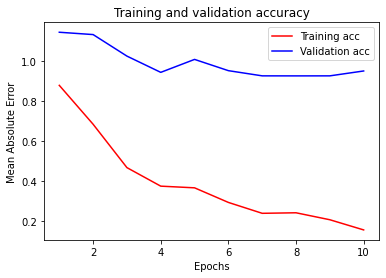

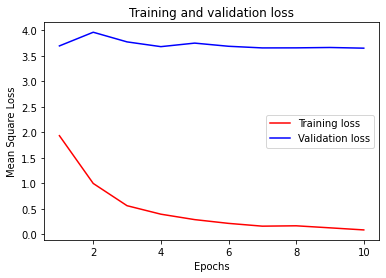

In [ ]:
# Visualization of accuracy and loss
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Loss')
plt.show()

Evaluating the above model on Test Data set

In [ ]:
clstm_model.evaluate(test_X_sequence,test_Y_sequence) # evaluating the model with test data

19/19 [==============================] - 24s 1s/step - loss: 3.6485 - mae: 0.9550


[3.648542881011963, 0.9550361633300781]

Prediction using the above model on the test data

In [ ]:
test_Y_pred = clstm_model.predict(test_X_sequence) #predicting the steering angle for test data

#Test Mean squared error
print('test_mean_squared_error')
mean_squared_error(test_Y_sequence,test_Y_pred)


test_mean_squared_error


3.6485426419519573

Visualizing Test Predictions vs test labels

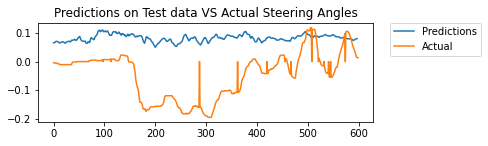

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(test_Y_pred, label = 'Predictions')
Actual = plt.plot(test_Y_sequence, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles")
plt.rcParams["figure.figsize"] = [14,9]
plt.savefig('test_predcitions_vs_labels_1')
plt.show()

**Model 3** - Data Augumentation on the above CLSTM model

57/57 [==============================] - 76s 1s/step - loss: 2.2402 - mae: 0.7314
test_mean_squared_error is:  3.6485426419519573


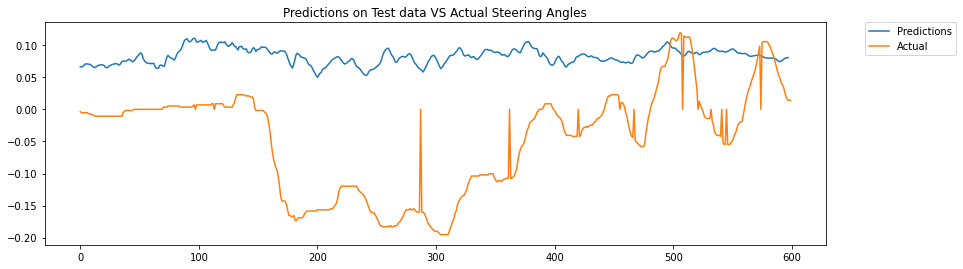

In [ ]:
#Data Augumentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# Loop for evaluating the model with data augumentation with train data
for X_batch, Y_batch in datagen.flow((train_X_final), train_Y, batch_size=1800):
    X_batch = train_X_sequence
    Y_batch = train_Y_sequence
    history = clstm_model.evaluate(X_batch, Y_batch)
    break
# Loop for evaluating the model with data augumentation with test data
for X_batch, Y_batch in datagen.flow((test_X_final), test_Y, batch_size=600):

    X_batch = train_X_sequence
    Y_batch = train_Y_sequence
    #evaluating the model for test data
    clstm_model.evaluate(X_batch, Y_batch)
    #predicting the values for test images
    test_Y_pred_1 = clstm_model.predict(test_X_sequence)
    print('test_mean_squared_error is: ', mean_squared_error(test_Y_sequence,test_Y_pred_1))
    #mean_squared_error(test_Y,test_Y_pred_1)
    #Visualizing test predictions vs test labels
    plt.subplot(211)
    Predicted = plt.plot(test_Y_pred_1, label = 'Predictions')
    Actual = plt.plot(test_Y, label = 'Actual')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Predictions on Test data VS Actual Steering Angles")
    plt.rcParams["figure.figsize"] = [14,9]
    plt.savefig('test_predcitions_vs_labels_2')
    plt.show()
    break

**Model 4** - CNN + LSTM ( with drop out 20 %) and optimizer as Adagrad 

In [ ]:
# Convolutional layers
clstm_model_1 = models.Sequential()

clstm_model_1.add(layers.InputLayer(input_shape=(3,66, 200, 3)))

# 1st CNN layer
clstm_model_1.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
#clstm_model.add(layers.TimeDistributed(MaxPooling2D(2, 2)))

# 2nd CNN layer
clstm_model_1.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
clstm_model_1.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#3rd CNN layer
clstm_model_1.add(layers.TimeDistributed(Convolution2D(128, (3, 3), activation='relu')))
clstm_model_1.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#4th CNN layer
clstm_model_1.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
clstm_model_1.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#5th CNN layer
clstm_model_1.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
clstm_model_1.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

clstm_model_1.add(layers.TimeDistributed(Flatten()))

#LSTM Layer

clstm_model_1.add(BatchNormalization(input_shape = (None, 3, 640)))
clstm_model_1.add(LSTM(256, dropout=0.2, recurrent_dropout=0.0,input_shape=(None, 3, 640)))

# Loop for evaluating the model with data augumentation with train data
clstm_model_1.add(Dense(64))
clstm_model_1.add(Dense(32))
clstm_model_1.add(layers.Dropout(0.2))
clstm_model_1.add(Dense(1))

#Dump the layer
clstm_model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_35 (TimeDi  (None, 3, 64, 198, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 3, 62, 196, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_37 (TimeDi  (None, 3, 31, 98, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_38 (TimeDi  (None, 3, 29, 96, 128)   73856     
 stributed)                                                      
                                                                 
 time_distributed_39 (TimeDi  (None, 3, 14, 48, 128)  

In [ ]:
clstm_model_1.compile(loss='mse', optimizer = 'adagrad', metrics=['mae']) # compiling the model
history = clstm_model_1.fit(train_X_sequence,train_Y_sequence, epochs=10, batch_size= 160, validation_data = (val_X_sequence,val_Y_sequence))

Epoch 1/10
12/12 [==============================] - 453s 37s/step - loss: 2.2790 - mae: 0.7422 - val_loss: 3.6383 - val_mae: 0.9897
Epoch 2/10
12/12 [==============================] - 431s 36s/step - loss: 2.2191 - mae: 0.7845 - val_loss: 3.6480 - val_mae: 1.0423
Epoch 3/10
12/12 [==============================] - 432s 36s/step - loss: 2.1915 - mae: 0.8162 - val_loss: 3.6629 - val_mae: 1.0841
Epoch 4/10
12/12 [==============================] - 428s 36s/step - loss: 2.1771 - mae: 0.8438 - val_loss: 3.6743 - val_mae: 1.1082
Epoch 5/10
12/12 [==============================] - 433s 36s/step - loss: 2.1779 - mae: 0.8612 - val_loss: 3.6858 - val_mae: 1.1293
Epoch 6/10
12/12 [==============================] - 439s 37s/step - loss: 2.1765 - mae: 0.8774 - val_loss: 3.6918 - val_mae: 1.1395
Epoch 7/10
12/12 [==============================] - 430s 36s/step - loss: 2.1736 - mae: 0.8822 - val_loss: 3.6969 - val_mae: 1.1476
Epoch 8/10
12/12 [==============================] - 436s 36s/step - loss: 2.

In [ ]:
clstm_model_1.save('clstm_model_1.h5') # saving the model

Visualizing the accuracy and loss for the above model

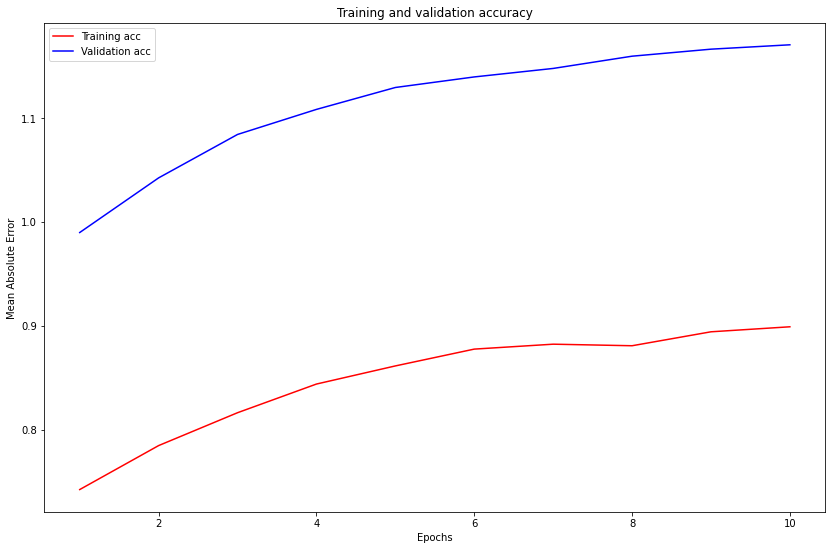

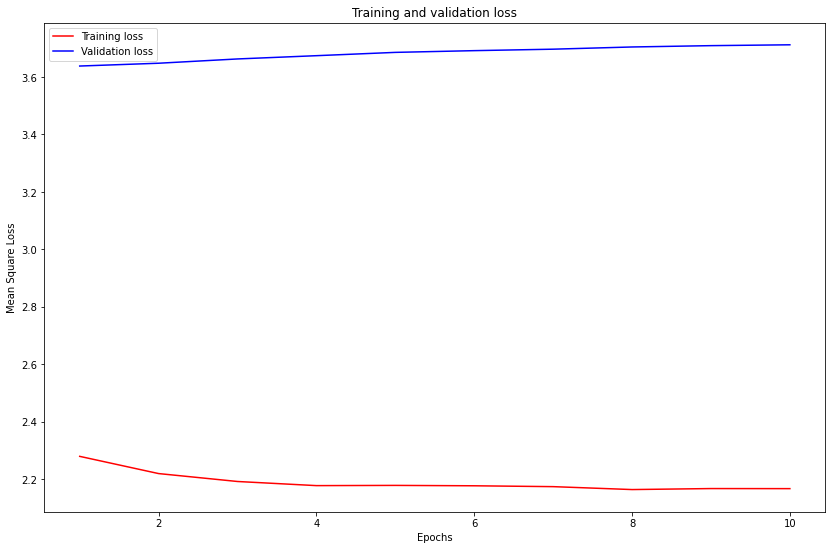

In [ ]:
# Visualization of accuracy and loss
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Loss')
plt.show()

Evaluating the model based on Test Data

In [ ]:
clstm_model_1.evaluate(test_X_sequence,test_Y_sequence) # evaluating the model with test data

19/19 [==============================] - 35s 2s/step - loss: 3.7124 - mae: 1.1704


[3.7123565673828125, 1.1703728437423706]

Comparison between predictions on test data and test labels

In [ ]:
test_Y_pred_12 = clstm_model_1.predict(test_X_sequence) #predicting the model

print('test_mean_squared_error')
mean_squared_error(test_Y_sequence,test_Y_pred_12) # mean squared error for predicted values and test labels

test_mean_squared_error


3.712356834000231

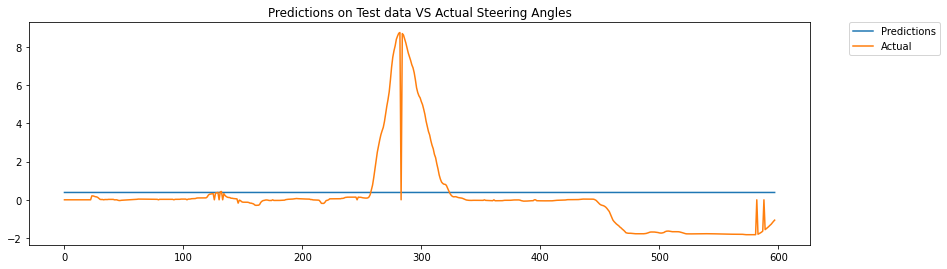

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(test_Y_pred_12, label = 'Predictions')
Actual = plt.plot(test_Y_sequence, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles")
plt.rcParams["figure.figsize"] = [14,9]
plt.savefig('test_predcitions_vs_labels_1')
plt.show()

**Model 5** - CNN + LSTM with drop out, regularizer, and optimizer as ADAM 

In [ ]:
# Convolutional layers
clstm_model_2 = models.Sequential()

clstm_model_2.add(layers.InputLayer(input_shape=(3,66, 200, 3)))

# 1st time distributed CNN layer
clstm_model_2.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
#clstm_model.add(layers.TimeDistributed(MaxPooling2D(2, 2)))

# 2nd CNN layer
clstm_model_2.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
clstm_model_2.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#3rd CNN layer
clstm_model_2.add(layers.TimeDistributed(Convolution2D(128, (3, 3), activation='relu')))
clstm_model_2.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#4th CNN layer
clstm_model_2.add(layers.TimeDistributed(Convolution2D(64, (3, 3), activation='relu')))
clstm_model_2.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

#5th CNN layer
clstm_model_2.add(layers.TimeDistributed(Convolution2D(32, (3, 3), activation='relu')))
clstm_model_2.add(layers.TimeDistributed(MaxPooling2D((2, 2))))

clstm_model_2.add(layers.TimeDistributed(Flatten()))

#LSTM Layer

clstm_model_2.add(BatchNormalization(input_shape = (None, 3, 640)))
clstm_model_2.add(LSTM(256, dropout=0.2, recurrent_dropout=0.0,input_shape=(None, 3, 640)))

# fully connected dense layer
clstm_model_2.add(Dense(64, kernel_regularizer=regularizers.l2(0.001)))
clstm_model_2.add(Dense(32))
clstm_model_2.add(layers.Dropout(0.2))
clstm_model_2.add(Dense(1))

# dump of the model
clstm_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_55 (TimeDi  (None, 3, 64, 198, 32)   896       
 stributed)                                                      
                                                                 
 time_distributed_56 (TimeDi  (None, 3, 62, 196, 64)   18496     
 stributed)                                                      
                                                                 
 time_distributed_57 (TimeDi  (None, 3, 31, 98, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_58 (TimeDi  (None, 3, 29, 96, 128)   73856     
 stributed)                                                      
                                                                 
 time_distributed_59 (TimeDi  (None, 3, 14, 48, 128)  

In [ ]:
#compiling
clstm_model_2.compile(loss='mse', optimizer = 'adam', metrics=['mae'])

#training
history = clstm_model_2.fit(train_X_sequence,train_Y_sequence, epochs=10, batch_size= 160, validation_data = (val_X_sequence,val_Y_sequence))

Epoch 1/10
12/12 [==============================] - 453s 37s/step - loss: 2.1338 - mae: 0.8700 - val_loss: 3.7524 - val_mae: 1.0712
Epoch 2/10
12/12 [==============================] - 449s 38s/step - loss: 1.7617 - mae: 0.8903 - val_loss: 3.8030 - val_mae: 0.9805
Epoch 3/10
12/12 [==============================] - 446s 37s/step - loss: 1.4110 - mae: 0.7870 - val_loss: 3.9223 - val_mae: 1.0667
Epoch 4/10
12/12 [==============================] - 436s 36s/step - loss: 1.1471 - mae: 0.6599 - val_loss: 5.1798 - val_mae: 1.4784
Epoch 5/10
12/12 [==============================] - 442s 37s/step - loss: 1.0101 - mae: 0.6228 - val_loss: 4.9969 - val_mae: 1.4357
Epoch 6/10
12/12 [==============================] - 445s 37s/step - loss: 0.7960 - mae: 0.5686 - val_loss: 3.7161 - val_mae: 0.9594
Epoch 7/10
12/12 [==============================] - 450s 38s/step - loss: 0.6601 - mae: 0.5132 - val_loss: 3.9948 - val_mae: 1.3838
Epoch 8/10
12/12 [==============================] - 450s 37s/step - loss: 0.

In [ ]:
clstm_model_2.save('clstm_model_2.h5') # saving the model

Visualizing the training and Validation accuracy and loss

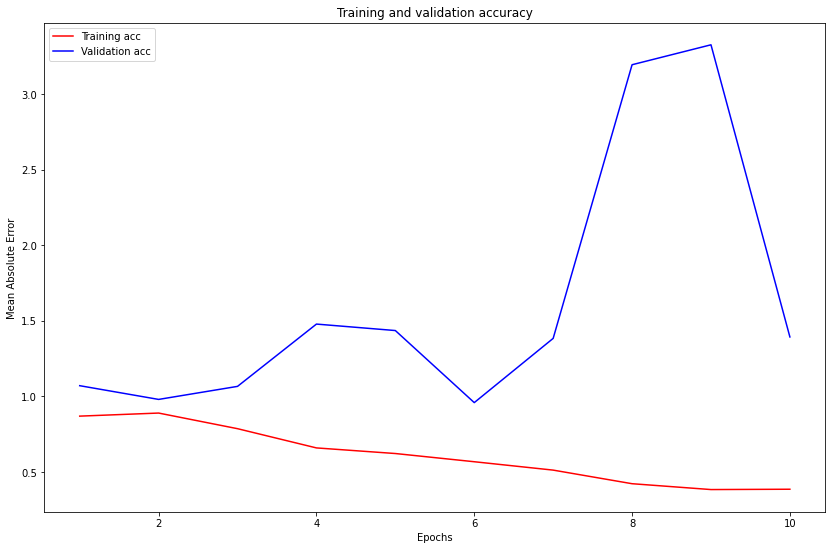

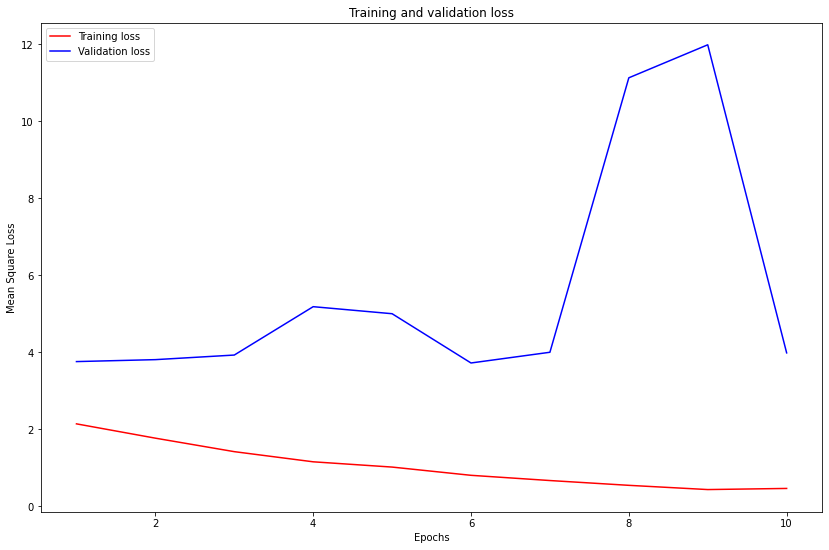

In [ ]:
# Visualization of accuracy and loss
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Square Loss')
plt.show()

In [ ]:
clstm_model_2.save('clstm_model_2.h5') # saving the model

In [ ]:
clstm_model_2.evaluate(test_X_sequence,test_Y_sequence) # evaluating the model on test data

19/19 [==============================] - 35s 2s/step - loss: 4.0557 - mae: 1.3537


[4.055656909942627, 1.3537076711654663]

In [ ]:
#Predictions on the test sequences
test_Y_pred_7 = clstm_model_2.predict(test_X_sequence)

#Test Mean squared error
print('test_mean_squared_error')
mean_squared_error(test_Y_sequence,test_Y_pred_7)

test_mean_squared_error


3.9785624063638596

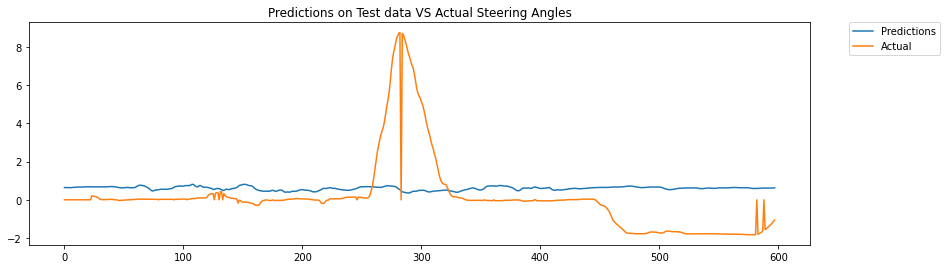

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(test_Y_pred_7, label = 'Predictions')
Actual = plt.plot(test_Y_sequence, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles")
plt.rcParams["figure.figsize"] = [14,9]
plt.savefig('test_predcitions_vs_labels_6')
plt.show()

**Model 6** - Transfer Learning

Using VGG16 as a feature extraction to train the CLSTM model

In [ ]:

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(66, 200, 3)) # Dumping VGG16
conv_base_x = conv_base.output # VGG16 output

# freezing the layers of VGG16
for layer in conv_base.layers:
    layer.trainable = False 

#dump the model summary
conv_base.summary()

In [ ]:
#Adding LSTM and dense layers to the VGG16
conv_base_x = TimeDistributed(Flatten())(conv_base_x) #conversting the output of the VGG16 with time distributed. so that it can be fed to LSTM layer
#conv_base_x = BatchNormalization(input_shape = (None, 1, 640)))
#LSTM
conv_base_x = LSTM(256, dropout=0.0, recurrent_dropout=0.0, return_sequences=False)(conv_base_x)

#dense layers addition
predictions = Dense(64, name="dense", activation="relu")(conv_base_x)
predictions = Dense(32, name="dense", activation="relu")(conv_base_x)
predictions = Dense(1, name="dense", activation="softmax")(conv_base_x)


In [ ]:
import keras

clstm_model_tl = keras.Model(inputs=conv_base.inputs, outputs=predictions) # Connecting whole VGG16 with LSTM and creating a model
clstm_model_tl.compile(optimizer='adam', loss='mse', metrics=['mae']) # compiling

#clstm_model_tl.fit(train_X_final,train_Y, epochs=10, batch_size= 160, validation_data=(val_X_final,val_Y),)

Saving the above model

In [ ]:
clstm_model_tl.save('clstm_model_tl.h5') # saving the model

Evaluating the above model on Train & Test Data set:

In [ ]:
clstm_model_tl.evaluate(train_X_final,train_Y) # Evaluating the model on tarin dataset

In [ ]:
clstm_model_tl.evaluate(test_X_final,test_Y) # Evaluating the model on test dataset

In [ ]:
#Predictions on the test sequences
test_Y_pred_2 = clstm_model_tl.predict(test_X_final)

#Test Mean squared error
print('test_mean_squared_error')
mean_squared_error(test_Y,test_Y_pred_2)

Visualizing the test predictions vs test labels

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(test_Y_pred_2, label = 'Predictions')
Actual = plt.plot(test_Y, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles")
plt.rcParams["figure.figsize"] = [14,9]
plt.savefig('test_predcitions_vs_labels_3')
plt.show()

**Model 7**: Fine Tuning with Transfer Learning

Training the top layer of VGG16 and using the output of it to feed LSTM Recurrent Neural Network

In [ ]:

conv_base_1 = VGG16(weights='imagenet', include_top=False, input_shape=(66, 200, 3)) # Dumping VGG16 model
conv_base_x1 = conv_base_1.output # Assigning output to a vaiable to convert it into time distributed inorder to feed it into LSTM

# unfreezing the last layer of VGG16 and freezing the rest of the layers
conv_base_1.trainable = True
set_trainable = False
for layer in conv_base_1.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

#Dump the model summary
conv_base_1.summary()

In [ ]:
#Adding LSTM and dense layers to the VGG16
conv_base_x1 = TimeDistributed(Flatten())(conv_base_x1)

#LSTM Layer
conv_base_x1 = LSTM(256, dropout=0.0, recurrent_dropout=0.0, return_sequences=False)(conv_base_x1)

#Dense layers
predictions = Dense(64, name="dense", activation="relu")(conv_base_x1)
predictions = Dense(32, name="dense", activation="relu")(conv_base_x1)
predictions = Dense(1, name="dense", activation="softmax")(conv_base_x1)


In [ ]:
clstm_model_ft = keras.Model(inputs=conv_base_1.inputs, outputs=predictions) #Connecting the model
clstm_model_ft.compile(optimizer='adam', loss='mse', metrics=['mae']) #Compiling the model

history = clstm_model_ft.fit(train_X_final,train_Y, epochs=3, batch_size= 160, validation_data = (val_X_final,val_Y)) 

# training the model as the last layer of the model is unfrozen and there is chance for training

In [ ]:
#saving the model
clstm_model_ft.save('clstm_model_ft.h5')

Evaluating the above model on Train & Test Data set:

In [ ]:
clstm_model_ft.evaluate(train_X_final,train_Y) #Evaluating the model on train data

In [ ]:
clstm_model_ft.evaluate(test_X_final,test_Y) #Evaluating the model on test data

In [ ]:
#Predictions on the test sequences
test_Y_pred_3 = clstm_model_ft.predict(test_X_final) # Prediction of steering angle for test images using the above model

#Test Mean squared error
print('test_mean_squared_error')
mean_squared_error(test_Y,test_Y_pred_3) #mean squared error between model prediction and test labels for the test data set

Visualizing the test predictions vs test labels

In [ ]:
#Visualizing test predictions vs test labels
plt.subplot(211)
Predicted = plt.plot(test_Y_pred_3, label = 'Predictions')
Actual = plt.plot(test_Y, label = 'Actual')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Predictions on Test data VS Actual Steering Angles")
plt.rcParams["figure.figsize"] = [14,9]
plt.savefig('test_predcitions_vs_labels_4')
plt.show()

**Model 8** - Feature Extraction with Data Augumentation

In [ ]:
# Data Augumentation
datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

# evaluating model 6 with augumentated input on train data set
for X_batch, Y_batch in datagen.flow((train_X_final), train_Y, batch_size=1800):
    history = clstm_model_tl.evaluate(X_batch, Y_batch)
    break

# evaluating model 6 with augumentated input on test data set
for X_batch, Y_batch in datagen.flow((test_X_final), test_Y, batch_size=600):
    clstm_model_ft.evaluate(X_batch, Y_batch)
    test_Y_pred_4 = clstm_model_tl.predict(test_X_final)
    print('test_mean_squared_error is: ', mean_squared_error(test_Y,test_Y_pred_4))
    
    #Visualizing test predictions vs test labels
    plt.subplot(211)
    Predicted = plt.plot(test_Y_pred_4, label = 'Predictions')
    Actual = plt.plot(test_Y, label = 'Actual')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title("Predictions on Test data VS Actual Steering Angles")
    plt.rcParams["figure.figsize"] = [14,9]
    plt.savefig('test_predcitions_vs_labels_5')
    plt.show()
    break

# Suggested Workflow

What I would recommend completing this notebook so that it does the necessary preprocessing of your raw data.  Then save the raw data to your Google Drive and then load it from there for training.  You do NOT want to be generating your data from scratch each time.  